In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm
import geopandas as gpd
from shapely.geometry import MultiPoint, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

In [32]:
dwellingTypes = pd.read_csv('../Data/structuralTypeOfDwelling_CT_2006.csv', dtype={'Geography':str})

In [33]:
profileData = pd.read_csv('../Data/Canada_CT_PopulationCensus_2006.csv', dtype={'Geography':str})

<h1>GEO FILES</h1>

In [102]:
zoneShape = gpd.read_file('../GeoFiles/new/Montreal_CT_w_csd_2006.shp')

In [103]:
zoneShape['zone'] = zoneShape.index+1

In [106]:
zoneShape.to_file('../GeoFiles/MontrealCTZones_with_int_zone_2006.shp')

In [105]:
zoneShape.head(20)

,CTUID,CMAUID,PRUID,CSDUID,geometry,zone
0,4620001.00,462,24,2466023,"POLYGON ((-390369.149 191919.811, -390549.949 ...",1
1,4620002.00,462,24,2466023,"POLYGON ((-391485.098 192180.669, -391501.439 ...",2
2,4620003.00,462,24,2466023,"POLYGON ((-391346.987 193357.142, -391366.695 ...",3
3,4620004.00,462,24,2466023,"POLYGON ((-391653.649 191789.232, -391667.935 ...",4
4,4620005.00,462,24,2466023,"POLYGON ((-391689.428 191706.161, -391653.649 ...",5
5,4620006.00,462,24,2466023,"POLYGON ((-390263.949 190450.272, -390476.129 ...",6
6,4620007.00,462,24,2466023,"POLYGON ((-393080.343 191364.871, -393071.960 ...",7
7,4620008.00,462,24,2466023,"POLYGON ((-390263.949 190450.272, -390258.034 ...",8
8,4620009.00,462,24,2466023,"POLYGON ((-392067.404 190822.903, -391847.223 ...",9
9,4620010.00,462,24,2466023,"POLYGON ((-393614.540 188185.277, -393500.908 ...",10


In [107]:
zoneSystem = pd.DataFrame(data=zoneShape['zone'].values, columns=['zone'], dtype=int)


In [108]:
zoneSystem['CTUID'] = zoneShape['CTUID'].astype(float).values

In [145]:
zoneSystem.head(15)

,zone,CTUID
0,1,4620001.00
1,2,4620002.00
2,3,4620003.00
3,4,4620004.00
4,5,4620005.00
5,6,4620006.00
6,7,4620007.00
7,8,4620008.00
8,9,4620009.00
9,10,4620010.00


<Axes: >

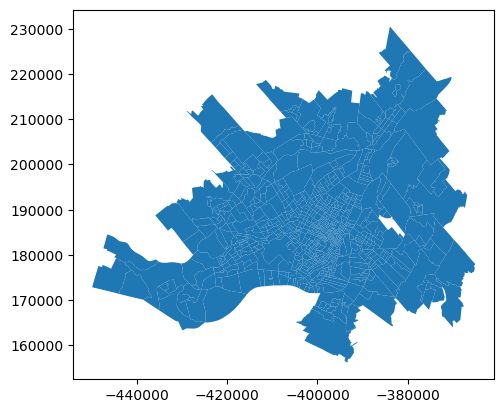

In [146]:
zoneShape.plot()

CREATE COMBINEDZONEDATA FILE

In [147]:
zoneData = pd.DataFrame(columns=['zone', 'Population', 'Employment rate', 'Area', "Total - Structural type of dwelling"])
for i, row in zoneSystem.iterrows():
    ctuid = float(row['CTUID'])
    zone = int(row['zone'])
    
    numDwellings=1300
    population = 400
    employment_rate = 70
    try:numDwellings = dwellingTypes.loc[dwellingTypes['Geography'].astype(float)==ctuid, 'Total - Structural type of dwelling'].iloc[0]
    except:pass
    try:population = int(profileData.loc[profileData['Geography'].astype(float)==ctuid, "Population"].iloc[0]);employment_rate=profileData.loc[profileData['Geography'].astype(float)==ctuid, 'Employment rate'].iloc[0]
    except:pass

    zoneData.loc[len(zoneData)] = [zone, population, employment_rate, float(zoneShape.loc[zoneShape['CTUID'].astype(float)==ctuid, 'geometry'].iloc[0].area), numDwellings]

zoneData['zone'] = zoneData['zone'].astype(int)
zoneData.to_csv('../Data/combinedZoneData.csv', index=False)

In [148]:
zoneData = pd.read_csv('../Data/combinedZoneData.csv')

In [149]:
totalPersons = zoneData['Population'].astype(int).sum()
totalPersons

3357254

In [150]:
def get_zone_int(zone):
    return int(zoneSystem.loc[zoneSystem['CTUID'].astype(float)==float(zone), 'zone'].iloc[0])

In [151]:
get_zone_int('4620012.01')

12

<h1>PERSONS</h1>

In [119]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [120]:
salary_distribution_employed = get_truncated_normal(mean=57000, sd=20000, low=30000, upp=100000)
salary_distribution_retired = get_truncated_normal(mean=30000, sd=15000, low=15000, upp=70000)
employment_incomes = salary_distribution_employed.rvs(int(totalPersons*.75))
retired_incomes = salary_distribution_retired.rvs(int(totalPersons*.25))

In [121]:
def getAge():
    rand = random.random()
    if rand < .33:
        return random.randint(0,20)
    elif rand < .63:
        return random.randint(20,39)
    elif rand < .86:
        return random.randint(40,60)
    elif rand < .98:
        return random.randint(60,80)
    elif rand < 1:
        return random.randint(80,100)

In [122]:
def createPerson(person:"np.ndarray"):
    person[1] = -1
    person[2] = getAge()
    person[3] = random.randint(0,1)
    person[4] = 2 if person[2] < 18 else np.random.randint(0, 2)
    person[5] = 0 if person[2] < 4 \
                    else 4 if person[2] > 65 \
                    else 2 if person[2] < 22 \
                    else 1 if np.random.random() < .70 \
                    else 2
    person[6] = 1
    person[7] = -1
    person[8] = -1
    if person[5]==1:
        person[8] = random.choice(employment_incomes)
    elif person[5]==4:
        person[8] = random.choice(retired_incomes)
    person[9] = -1
    # NATIONALITY

    if person[0]%10000==0:
        print(person[0])
    return person

In [152]:
persons = np.empty([totalPersons,10]) # without nationality, add after

In [153]:
persons[:,0] = np.arange(0, totalPersons, 1)

In [154]:
np.apply_along_axis(createPerson, 1, persons)

0.0
10000.0
20000.0
30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0
100000.0
110000.0
120000.0
130000.0
140000.0
150000.0
160000.0
170000.0
180000.0
190000.0
200000.0
210000.0
220000.0
230000.0
240000.0
250000.0
260000.0
270000.0
280000.0
290000.0
300000.0
310000.0
320000.0
330000.0
340000.0
350000.0
360000.0
370000.0
380000.0
390000.0
400000.0
410000.0
420000.0
430000.0
440000.0
450000.0
460000.0
470000.0
480000.0
490000.0
500000.0
510000.0
520000.0
530000.0
540000.0
550000.0
560000.0
570000.0
580000.0
590000.0
600000.0
610000.0
620000.0
630000.0
640000.0
650000.0
660000.0
670000.0
680000.0
690000.0
700000.0
710000.0
720000.0
730000.0
740000.0
750000.0
760000.0
770000.0
780000.0
790000.0
800000.0
810000.0
820000.0
830000.0
840000.0
850000.0
860000.0
870000.0
880000.0
890000.0
900000.0
910000.0
920000.0
930000.0
940000.0
950000.0
960000.0
970000.0
980000.0
990000.0
1000000.0
1010000.0
1020000.0
1030000.0
1040000.0
1050000.0
1060000.0
1070000.0
1080000.0
1090000.0
1100000.0
1110

array([[ 0.00000000e+00, -1.00000000e+00,  3.00000000e+01, ...,
        -1.00000000e+00,  4.16617843e+04, -1.00000000e+00],
       [ 1.00000000e+00, -1.00000000e+00,  5.60000000e+01, ...,
        -1.00000000e+00,  6.57568527e+04, -1.00000000e+00],
       [ 2.00000000e+00, -1.00000000e+00,  5.30000000e+01, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       ...,
       [ 3.35725100e+06, -1.00000000e+00,  3.40000000e+01, ...,
        -1.00000000e+00,  6.16258395e+04, -1.00000000e+00],
       [ 3.35725200e+06, -1.00000000e+00,  3.30000000e+01, ...,
        -1.00000000e+00,  4.66058752e+04, -1.00000000e+00],
       [ 3.35725300e+06, -1.00000000e+00,  3.50000000e+01, ...,
        -1.00000000e+00,  9.72857962e+04, -1.00000000e+00]])

In [155]:
outputPersons = pd.DataFrame(columns=['id','hhId','age','gender','relationship','occupation','occupation_type','workplace','income','schoolplace'], data=persons.astype(int))

In [156]:
outputPersons.to_csv('../Output/pp_2006_unlinked.csv', index=False)

<h1>DWELLINGS</h1>

In [128]:
streetNetwork_nodes = gpd.read_file('../GeoFiles/streetNetwork_nodes.gpkg')
roadPoints = streetNetwork_nodes['geometry']
roadNodes = MultiPoint(roadPoints)

In [157]:
dwelling_counts = pd.read_csv('../Data/structuralTypeOfDwelling_CT_2006.csv', dtype={'Geography':float})

In [158]:
zoneShape = gpd.read_file('../GeoFiles/MontrealCTZones_with_int_zone_2006.shp')

In [159]:
dwelling_counts = dwelling_counts[dwelling_counts['Geography'].astype(float).isin(zoneShape['CTUID'].astype(float))]
dwelling_counts = dwelling_counts.reset_index(drop=True)

In [160]:
totalDwellings = dwelling_counts['Total - Structural type of dwelling'].astype(float).sum()
totalDwellings

1411090.0

CEATE DWELLING COORDINATES

In [164]:
zoneData

,zone,Population,Employment rate,Area,Total - Structural type of dwelling
0,1,2498.0,57.80,1.081347e+06,1240.0
1,2,2819.0,56.80,3.871678e+05,1340.0
2,3,6407.0,60.00,7.404335e+05,2885.0
3,4,3223.0,58.50,4.523133e+05,1560.0
4,5,3188.0,58.00,9.148390e+05,1600.0
...,...,...,...,...,...
816,817,3609.0,70.90,1.356089e+06,1320.0
817,818,4440.0,79.60,1.180945e+06,1430.0
818,819,5208.0,64.40,3.261419e+07,2065.0
819,820,4506.0,64.90,5.023961e+07,1765.0


In [165]:
zoneShapeClone = zoneShape[:]

polygons = []
for i in range(zoneShapeClone.shape[0]):
    polygons.append(zoneShapeClone.iloc[i]['geometry'])
    
geoseries = gpd.GeoSeries(polygons, zoneData['zone'])
dwelling_coords = geoseries.sample_points(size=zoneData['Total - Structural type of dwelling'].astype(float).astype(int))
dwelling_coords = dwelling_coords.explode(index_parts=True)

CREATE DWELLINGS

In [166]:
dwellings = np.empty([int(totalDwellings), 14], dtype=object)

In [167]:
dwellings[:,0] = np.arange(0, totalDwellings, 1)

In [168]:
lastDwelling = 0
iters = 0
for ind, zone_dwellings in dwelling_counts.iterrows():
    print(iters)
    iters+=1
    count = int(float(zone_dwellings['Total - Structural type of dwelling']))
    zone = get_zone_int(zone_dwellings['Geography'])

    dwellings[lastDwelling:lastDwelling+count,1] = zone

    # apply structural types of dwellings
    lastDwellingTypeIndex = lastDwelling
    SFD = int(float(zone_dwellings['Single-detached house']))
    SFA = int(float(zone_dwellings['Semi-detached house']))
    MF234 = int(float(zone_dwellings['Apartment, duplex']) + \
        float(zone_dwellings['Row house']))
    MF5plus = int(float(zone_dwellings['Apartment, building that has five or more storeys']) + \
        float(zone_dwellings['Apartment, building that has fewer than five storeys']))
    MH = int(float(zone_dwellings['Movable dwelling']))

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFD,2] = 0
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFD,9] = [2200 + random.randint(-400,400) for i in range(SFD)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+SFD

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFA,2] = 1
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFA,9] = [1100 + random.randint(-200, 100) for i in  range(SFA)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+SFA

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF234,2] = 2
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF234,9] = [400 + random.randint(-300, 100) for i in range(MF234)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+MF234

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF5plus,2] = 3
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF5plus,9] = [400 + random.randint(-300, 100) for i in range(MF5plus)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+MF5plus

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MH,2] = 4
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MH,9] = 400 # This is off cause I don't know what MH is
    lastDwellingTypeIndex = lastDwellingTypeIndex+MH

    dwellings[lastDwellingTypeIndex:lastDwelling+count,2] = 0
    # # DONE DWELLING TYPES

    # # hhId set to 0 until linking
    dwellings[lastDwelling:lastDwelling+count,3] = -1

    # # number of bedrooms
    dwellings[lastDwelling:lastDwelling+count,4] = random.randint(1,4)

    # # quality of dwelling
    quality = [random.randint(1,4) for i in range(count)]
    dwellings[lastDwelling:lastDwelling+count,5] = quality

    # # monthly cost
    costs = np.apply_along_axis(lambda x:2500 - (x-1)*350, 1, np.array([quality]))
    dwellings[lastDwelling:lastDwelling+count,6] = costs

    # # restriction
    dwellings[lastDwelling:lastDwelling+count,7] = 0

    # # year built
    construction_years = np.apply_along_axis(lambda x:random.randint(1980, 2006) - (x-1)*20, 1, np.array([quality]))
    dwellings[lastDwelling:lastDwelling+count,8] = construction_years

    # dwellings[lastDwelling:lastDwelling+count,2:9] = [0,-1,random.randint(1,4),quality,2500 - (quality-1)*350,0,random.randint(1980, 2006) - (quality-1)*20]
    # building (size)
    dwellings[lastDwelling:lastDwelling+count,10] = 2 # medium building

    # # usage (unused)
    dwellings[lastDwelling:lastDwelling+count,11] = 0

    

    # # choose coordinate position for dwelling inside correct zone
    for d in range(count):
        point = Point(float(random.choice(dwelling_coords[zone]).x), float(random.choice(dwelling_coords[zone]).y))
        # p1, p2 = nearest_points(point, roadNodes)
        dwellings[lastDwelling+d,12] = point.x
        dwellings[lastDwelling+d,13] = point.y


    lastDwelling+=count


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

SNAP THREADING

In [169]:
import threading

In [170]:
def snap_position(dwelling):
    point = Point(dwelling[12], dwelling[13])
    p1,p2 = nearest_points(point, roadNodes)
    dwelling[12] = p2.x
    dwelling[13] = p2.y

    if dwelling[0]%10000==0:
        print(dwelling[0])

In [ ]:
threads = []
count = 0
for i in range(int(dwellings.shape[0]/100000)+1):
    threads.append(threading.Thread(target=np.apply_along_axis, args=[snap_position, 1, dwellings[count:count+100000]]))
    print(i, ':', count, count+100000)
    count+=100000
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()



0 : 0 100000
1 : 100000 200000
2 : 200000 300000
3 : 300000 400000
4 : 400000 500000
5 : 500000 600000
6 : 600000 700000
7 : 700000 800000
8 : 800000 900000
9 : 900000 1000000
10 : 1000000 1100000
11 : 1100000 1200000
12 : 1200000 1300000
13 : 1300000 1400000
14 : 1400000 1500000
0.0
400000.0
600000.0
700000.0
100000.0
300000.0
800000.0
200000.0
500000.0
1200000.0
1300000.0
1100000.0
900000.0
1000000.0
1400000.0
1010000.0
910000.0
510000.0
710000.0
10000.0
810000.0
110000.0
1110000.0
210000.0
1210000.0
410000.0
310000.0
610000.0
1410000.0
1310000.0
920000.0
1020000.0
520000.0
720000.0
20000.0
220000.0
1120000.0
420000.0
120000.0
1220000.0
320000.0
820000.0
620000.0
1320000.0
930000.0
1030000.0
730000.0
1130000.0
530000.0
30000.0
230000.0
330000.0
1230000.0
430000.0
830000.0
130000.0
630000.0
1330000.0
940000.0
1040000.0
1140000.0
740000.0
540000.0
40000.0
440000.0
1240000.0
240000.0
340000.0
840000.0
140000.0
640000.0
1340000.0
950000.0
1050000.0
1150000.0
750000.0
550000.0
50000.0
450

In [131]:

dwelling_cols = ['id','zone','type','hhId','bedrooms','quality','monthlyCost','restriction','yearBuilt','floor','building','usage','coordX','coordY']
pd.DataFrame(data=dwellings, columns=dwelling_cols).to_csv('../Output/dd_2006_snapped_unlinked.csv', index=False)

<h1>JOBS</h1>

CLEAN DATA

tmpJobData = pd.read_csv('./Data/jobData.csv', encoding_errors='replace')
for i in range(tmpJobData.shape[0]):
    geog = str(tmpJobData.loc[i, 'Geography']).split(' ')[0]
    try:
        float(geog)
        tmpJobData.loc[i, 'Geography'] = geog
    except:
        pass
        print('drop', geog)
        

tmpJobData.to_csv('./jobData_clean.csv', index=False)

READ CLEAN FILE BY CT ZONE AND FILTER

In [179]:
CT_job_data = pd.read_csv('../Data/jobData_CT_2006_OLD.csv', encoding_errors='replace', dtype={'Geography':str})
CT_job_data = CT_job_data[(CT_job_data['Total']!='..') & (CT_job_data['Total']!='x')]   

In [180]:
CT_job_data.shape

(1377, 24)

only jobs in interested zones

In [181]:
CT_job_data = CT_job_data[CT_job_data['Geography'].astype(float).isin(zoneSystem['CTUID'].astype(float))]

In [182]:
CT_job_data['Total'].astype(int).sum()

1701295

In [183]:
jobs_per_ct = CT_job_data.astype({'Geography':float})

In [184]:
jobs_per_ct

,Geography,Total,Industry - not applicable,All industries,"11 Agriculture, forestry, fishing and hunting","21 Mining, quarrying, and oil and gas extraction",22 Utilities,23 Construction,31-33 Manufacturing,41 Wholesale trade,...,53 Real estate and rental and leasing,"54 Professional, scientific and technical services",55 Management of companies and enterprises,"56 Administrative and support, waste management and remediation services",61 Educational services,62 Health care and social assistance,"71 Arts, entertainment and recreation",72 Accommodation and food services,81 Other services (except public administration),91 Public administration
392,4620001.00,1480,55,1430,0,0,10,95,90,45,...,25,125,0,45,125,260,40,65,50,110
393,4620002.00,1935,80,1855,0,0,0,135,150,55,...,25,100,0,110,130,320,35,90,95,100
394,4620003.00,3445,80,3360,10,0,15,200,260,145,...,30,190,0,225,235,640,35,210,150,225
395,4620004.00,1735,35,1700,10,0,0,135,145,40,...,30,155,0,90,130,310,15,95,60,80
396,4620005.00,1835,50,1780,0,0,15,115,160,70,...,20,145,0,100,80,305,30,90,75,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,4620904.05,1835,30,1810,15,0,25,165,265,65,...,35,110,0,70,165,255,30,35,75,95
1343,4620904.06,2595,30,2565,15,0,55,215,305,80,...,25,210,0,75,225,350,45,85,70,215
1344,4620926.01,2985,45,2940,25,0,15,335,415,85,...,45,220,0,90,245,435,50,120,135,135
1345,4620926.02,2525,15,2505,45,0,20,325,285,85,...,30,125,0,100,195,350,25,95,90,115


Job coords geoseries

In [160]:
polygons = []
zoneShapeClone = zoneShape[:]
for i in range(zoneShapeClone.shape[0]):
    polygons.append(zoneShapeClone.iloc[i]['geometry'])
print(len(polygons))

geoseries = gpd.GeoSeries(polygons, zoneShapeClone['CTUID'])
job_coords = geoseries.sample_points(size=jobs_per_ct['Total'].astype(int))
job_coords = job_coords.explode(index_parts=True)

753


In [185]:
job_headers = ["11 Agriculture, forestry, fishing and hunting","21 Mining, quarrying, and oil and gas extraction",'22 Utilities','23 Construction','31-33 Manufacturing','41 Wholesale trade','44-45 Retail trade','48-49 Transportation and warehousing','51 Information and cultural industries','52 Finance and insurance','53 Real estate and rental and leasing',"54 Professional, scientific and technical services",'55 Management of companies and enterprises',"56 Administrative and support, waste management and remediation services",'61 Educational services','62 Health care and social assistance',"71 Arts, entertainment and recreation",'72 Accommodation and food services','81 Other services (except public administration)','91 Public administration']

In [186]:
job_type_indexes = ["Agri","Mnft","Util","Cons","Retl","Trns","Finc","Rlst","Admn","Serv"]

In [187]:
def translate_job_type(job_typ):
    typ = ''
    match job_typ:
        case "11 Agriculture, forestry, fishing and hunting":
            typ = 'Agri'
        case "21 Mining, quarrying, and oil and gas extraction":
            typ = 'Mnft'
        case "22 Utilities":
            typ = 'Util'
        case "23 Construction":
            typ = 'Cons'
        case "31-33 Manufacturing":
            typ = 'Mnft'
        case "41 Wholesale trade":
            typ = 'Serv'
        case "44-45 Retail trade":
            typ = 'Retl'
        case "48-49 Transportation and warehousing":
            typ = 'Trns'
        case "51 Information and cultural industries":
            typ = 'Serv'
        case "52 Finance and insurance":
            typ = 'Finc'
        case "53 Real estate and rental and leasing":
            typ = 'Rlst'
        case "54 Professional, scientific and technical services":
            typ = 'Serv'
        case "55 Management of companies and enterprises":
            typ = 'Admn'
        case "56 Administrative and support, waste management and remediation services":
            typ = 'Admn'
        case "61 Educational services":
            typ = 'Serv'
        case "62 Health care and social assistance":
            typ = 'Serv'
        case "71 Arts, entertainment and recreation":
            typ = 'Serv'
        case "72 Accommodation and food services":
            typ = 'Serv'
        case "81 Other services (except public administration)":
            typ = 'Serv'
        case "91 Public administration":
            typ = 'Admn'
        case _:
            pass
    return typ


In [ ]:
jobs = pd.DataFrame(columns=['id','zone','personId','type','coordX','coordY','startTime','duration'])
numJobs = 0
total_jobs = CT_job_data[0:300]['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017'].astype(float).sum()
for i, ct_area in CT_job_data[0:300].iterrows():
    ct_area_jobs = int(ct_area['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017'])
    da_areas = zoneShape.loc[zoneShape['CTUID']==ct_area['Geography'], 'DAUID']
    job_types = ct_area[job_headers]
    print(job_types)
    try:
        job_dist = random.choices(list(job_types.index), list(job_types.values.astype(int)), k=ct_area_jobs)
    except:
        print('no jobs in zone')
    for da_in_ct in da_areas:
        da_jobs = int(ct_area_jobs/len(da_areas))
        for job_num in range(da_jobs):
            jobs.loc[len(jobs)] = [numJobs, da_in_ct, -1, translate_job_type(random.choice(job_dist)), job_coords[da_in_ct][job_num].x, job_coords[da_in_ct][job_num].y, 32400, 28800]
            numJobs+=1
    print(str(numJobs/total_jobs*100)+'%')


jobs = jobs[jobs['zone'].astype(str).isin(zoneShape['DAUID'])]
jobs.to_csv('./jj_2006_pt1.csv', index=False)

In [198]:
jobs = pd.DataFrame(columns=['id','zone','personId','type','coordX','coordY','startTime','duration'])
numJobs = 0
for i, ct_zone in jobs_per_ct.iterrows():
    ct_area_jobs = int(ct_zone['Total'])
    job_types = ct_zone[job_headers]
    try:
        job_dist = random.choices(list(job_types.index), list(job_types.values.astype(int)), k=ct_area_jobs)
    except:
        print('no jobs in zone')
    
    for job_num in range(ct_area_jobs):
        jobs.loc[len(jobs)] = [numJobs, get_zone_int(ct_zone['Geography']), -1, translate_job_type(random.choice(job_dist)), job_coords[ct_zone['Geography']][job_num].x, job_coords[ct_zone['Geography']][job_num].y, 32400, 28800]
        numJobs += 1

jobs.to_csv('../Output/jj_2006.csv', index=False)

In [4]:
jobs = pd.read_csv('../Output/jj_2006.csv')

In [5]:
def snap_position_jobs(job):
    point = Point(job[4], job[5])
    p1,p2 = nearest_points(point, roadNodes)
    job[4] = p2.x
    job[5] = p2.y

    if job[0]%10000==0:
        print(job[0])

In [6]:
jb_values = jobs.values

In [ ]:
import threading

threads = []
count = 0
for i in range(int(jobs.shape[0]/100000)+1):
    threads.append(threading.Thread(target=np.apply_along_axis, args=[snap_position_jobs, 1, jb_values[count:count+100000]]))
    print(i, ':', count, count+100000)
    count+=100000
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()



In [8]:
pd.DataFrame(columns=jobs.columns, data=jb_values).to_csv('../Output/jj_2006_snapped_unlinked.csv', index=False)

<h1>ZoneSystem file</h1>

In [2]:
zoneShape = gpd.read_file('../GeoFiles/Montreal_CT_w_csd_2006.shp')

In [6]:
zoneSystem = pd.DataFrame(columns=['Zone', 'Area', 'distanceToTransit', 'BBSR_Type', 'Region'])

In [7]:
for i, zone in zoneShape.iterrows():
    zoneSystem.loc[i] = [zone['CTUID'], zone['geometry'].area, 7, 20, zone['CSDUID']]
    zoneSystem.loc[i, 'Area'] = zone['geometry'].area
    zoneSystem.loc[i, 'distanceToTransit'] = 7
    zoneSystem.loc[i, 'BBSR_Type'] = 20
    zoneSystem.loc[i, 'Region = '] = 20

In [8]:
zoneSystem.to_csv('../Output/zoneSystem.csv', index=False, encoding='utf-8')

<h1>DEVELOPMENT FILE</h1>

In [12]:
development = pd.DataFrame(columns=['Zone','SFD','SFA','MF234','MF5plus','MH', 'DevCapacity', 'DevLandUse'])
for i, data in zoneData.iterrows():
    development.loc[i] = [data['CTUID'], 1, 1, 1, 1, 1, float(data['Total - Structural type of dwelling'])*1.2, float(data['Area'])*1.2]

development.to_csv('../Output/development.csv', index=False)